# 18CHE147 End Semester Presentation

# Topic : VLE Data Analysis and Distillation Column Transient Characteristics Study

In [1]:
# Import Necessary libraries and modules
import pandas as pd
from PIL import Image
import IPython.display as IPdisplay

from AnalyzeVLE import AnalyzeVLE
from BinaryDistillation import BinaryDistillation


from PureComponentData import purecomponentdata

%matplotlib inline
%config InlineBackend.figure_format = 'retina'

# VEL Analysis Tool:

## This tool takes in a DataFrame object and a list of names of the compounds (As specified in Perry's Handbook) <br> The tool creates objects that contain all the information regarding the VLE System and also returns an NRTL object which can be further put to use

## Specifications needed in the Data File:
<ol>
<li>$T$: Temperature in K </li>
<li>$x1$: Liquid Phase Mole Fraction of MVC </li>
<li>$y1$: Vapour Phase Mole Fraction of MVC</li>
<li>$P$ : Pressure in kPa </li>
<li>Ref: Indicates different data sets </li>
    <li> All the above mentioned features should be ranging from row A through E </li>
</ol>

### Cerate a pandas DataFrame object to enter into the Tool 

### Here we have chosen compounds Hexane and Benzene

In [2]:
df_vle = pd.read_excel('benzene_hexane_vle.xlsx', usecols = 'A:E')

### Creating the VLE analyser object

In [3]:
VLEObj = AnalyzeVLE(['n-Hexane', 'Benzene'], df_vle)

### Initialize the variables, the tool starts creating the necessary variables <br> The process_data method will categorize the data according to the reference numbers given (you can specify upto which reference number to be taken). It will also eliminate those points in the data set that are not redundant and mat cause problems.

In [4]:
VLEObj.initialize_reading()
VLEObj.process_data(ref_no = 2)

### The visualize_data method provides a way to visualize the VLE data and user can analyse the trends in the data set and make a decision. The method provides a T-x-y diagram as well as a y-x diagram.

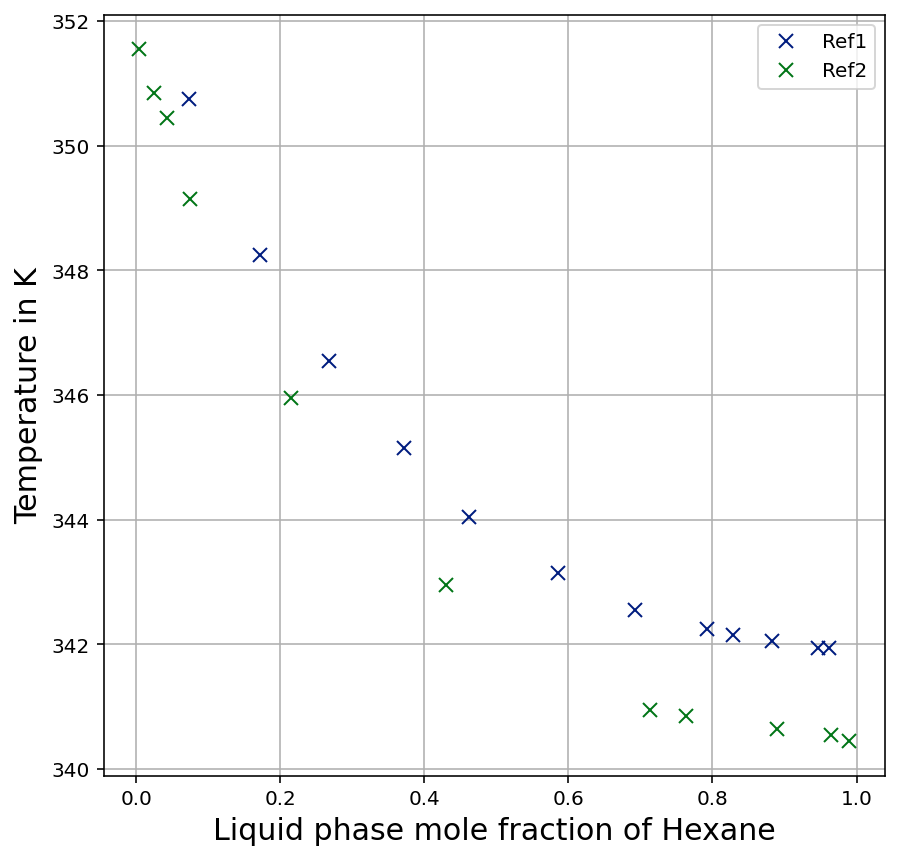

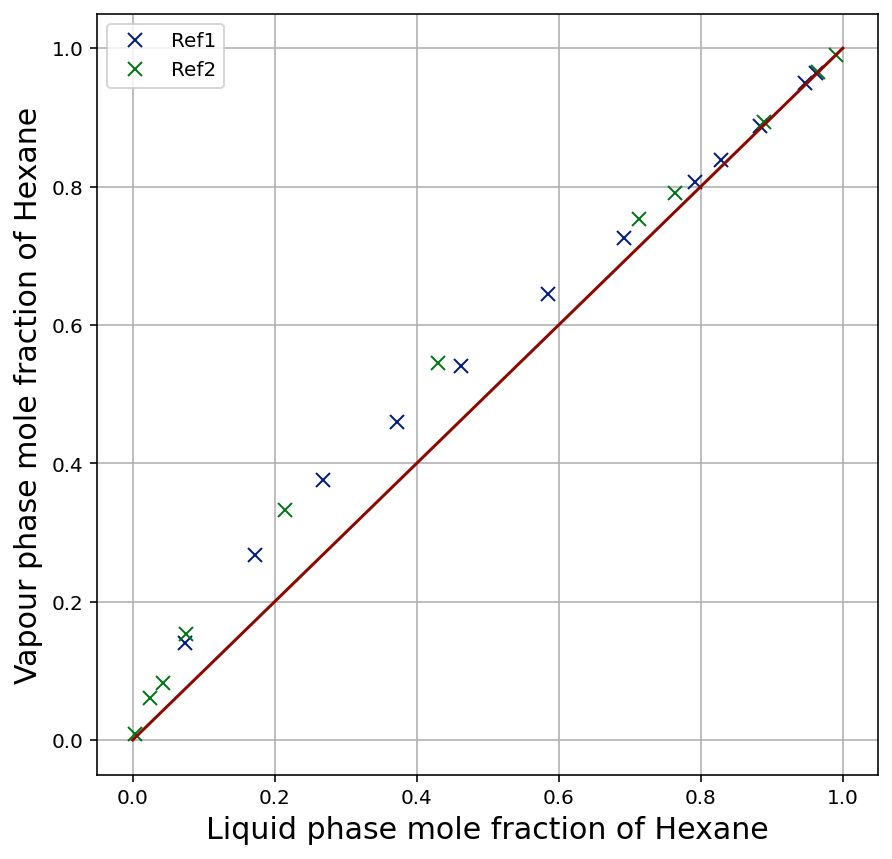

In [5]:
VLEObj.visualize_data()

### The get_expt_gamma method will determine the experimental values of Activity coefficients and store it in the DataFrame object

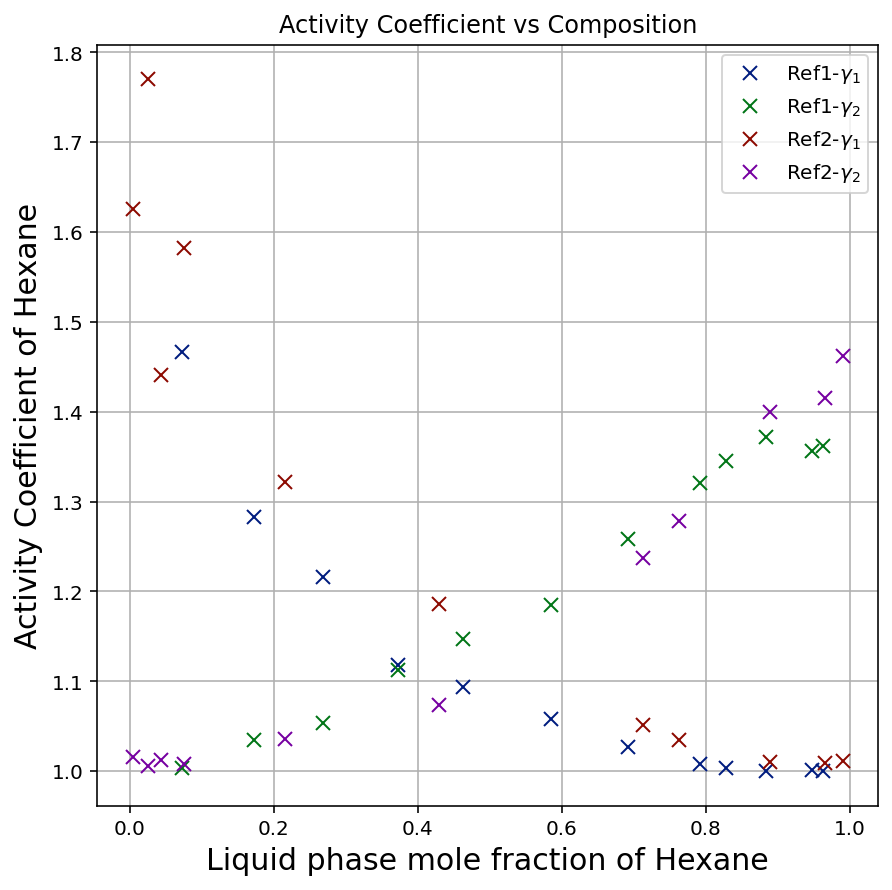

In [6]:
VLEObj.get_expt_gamma()

### The fit_nrtl method will correlate the data with the activity coefficients using the NRTL Model and will return three outputs. The NRTL object, fitted parameters and the function cost after optimization

In [7]:
nrtl, params, cost = VLEObj.fit_nrtl() 

### The observe_fit method will show the user how the activity coefficients are correlated by comparing them with the experimental values of the same. <br> There is also an option for the user to cancel the output of the Excess Gibbs free energy plot, which is set True by default
observe_fit(Gex = False) will suppress the Output 

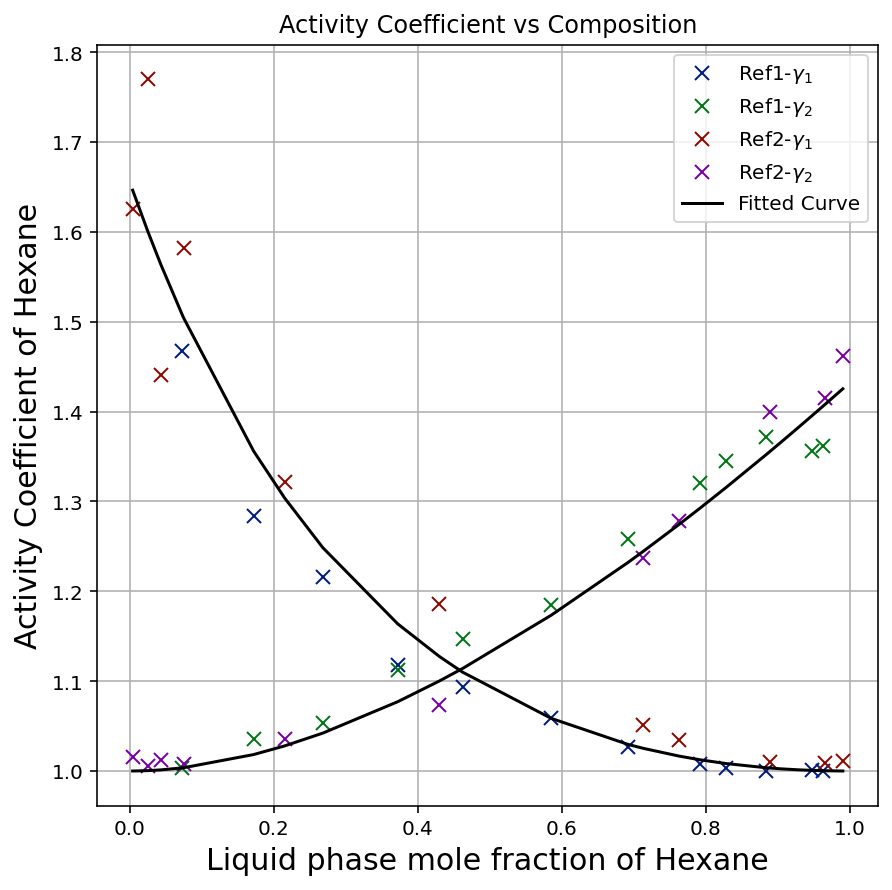

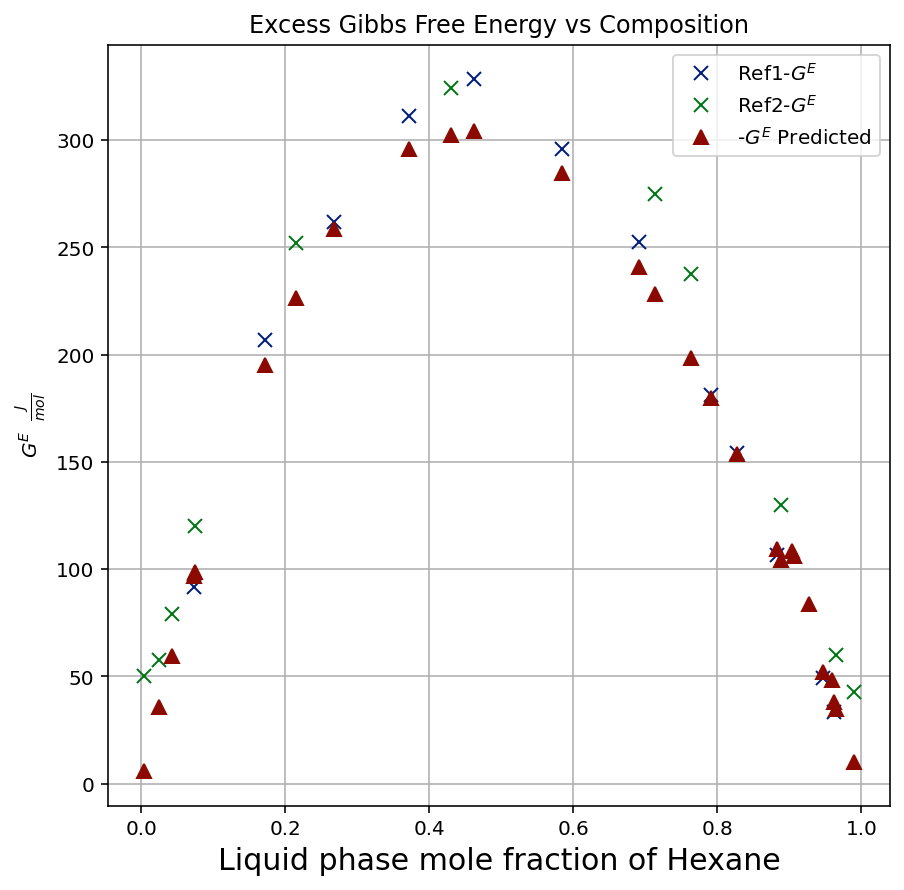

In [8]:
VLEObj.observe_fit()

# Simulating the Transient characteristics of a Distillation Column

## For this, I have written a Tool which helps the user to enter simple parameters and the objective of the tool is to provide a visualization of the transient behavior of the distillation column, especially during a start-up operation.

## The tool : BinaryDistillation needs two input: The NRTL object of the specific VLE system (which can be obtained from the AnalyzeVLE tool) and a dictionary of compunds (NOTE: the key of dictionary should not contain any special characters)

### We will continue with the Hexane-Benzene system:

In [9]:
Hexane = purecomponentdata.Compound("n-Hexane")  # More volatile component, (1)
Benzene = purecomponentdata.Compound('Benzene')  # Lesser volatile component, (2)

dict_compounds = {"Hexane":Hexane, "Benzene":Benzene} # Define the dictionary

### Initializing the variables. The user can vary any parameters they want. The parameters that can be varied are:
<ol>
<li> Input flowrate, $F, kmol/hr$ </li>
<li> Top product composition, $xd$ </li>
<li> Feed composition, $xf$ </li>
<li> Feed quality, $q$ </li>
    <li> Ratio between Actual Reflux ratio and Minimum Reflux ratio, $R$ (Should be >1) </li>
<li> Total Pressure, $Pt, Pa$ (assumed to be constant throughout) </li>
    

### Here we have created the distillation object and entered the necessary parameters

In [10]:
dist = BinaryDistillation(nrtl, dict_compounds)
dist.xd = 0.7
dist.xf = 0.5
dist.q = 1
dist.R = 3



### The show_xy and show_txy methods will show us the x-y and the T-x-y diagrams for the system:

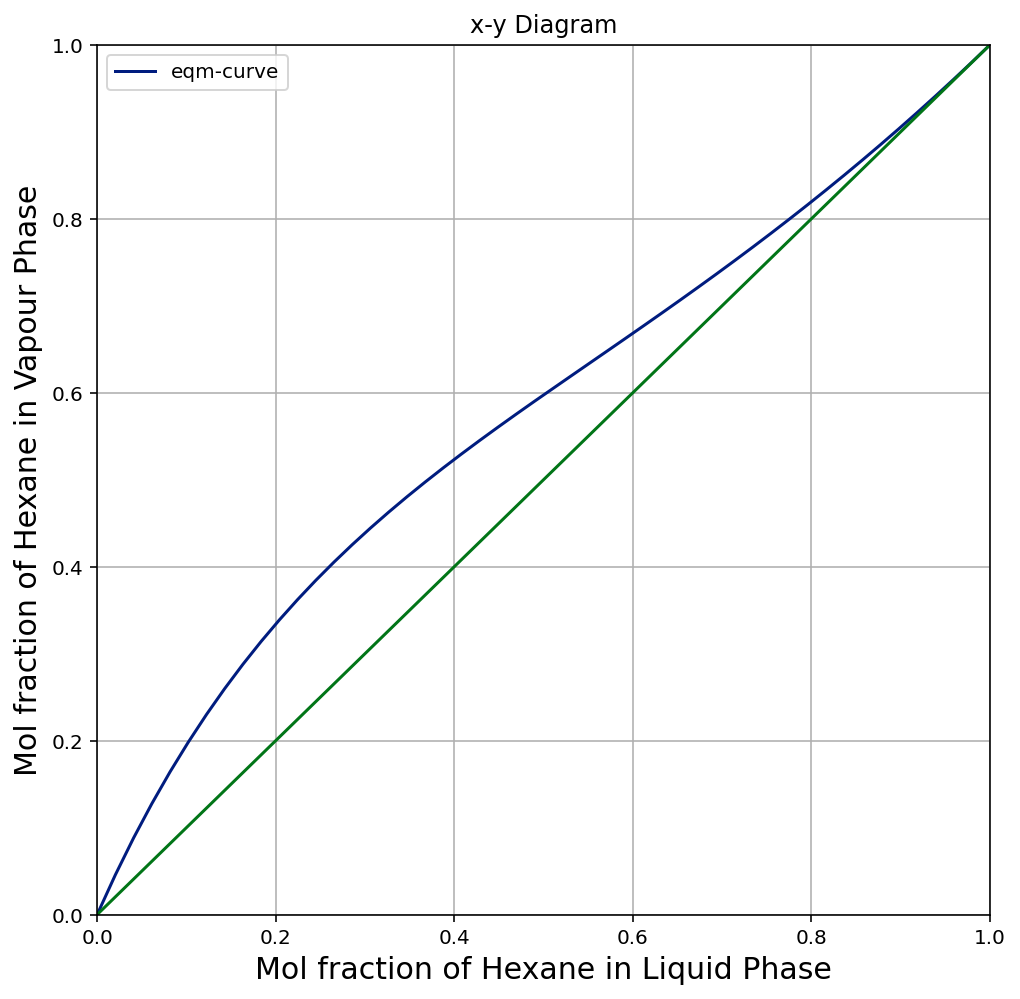

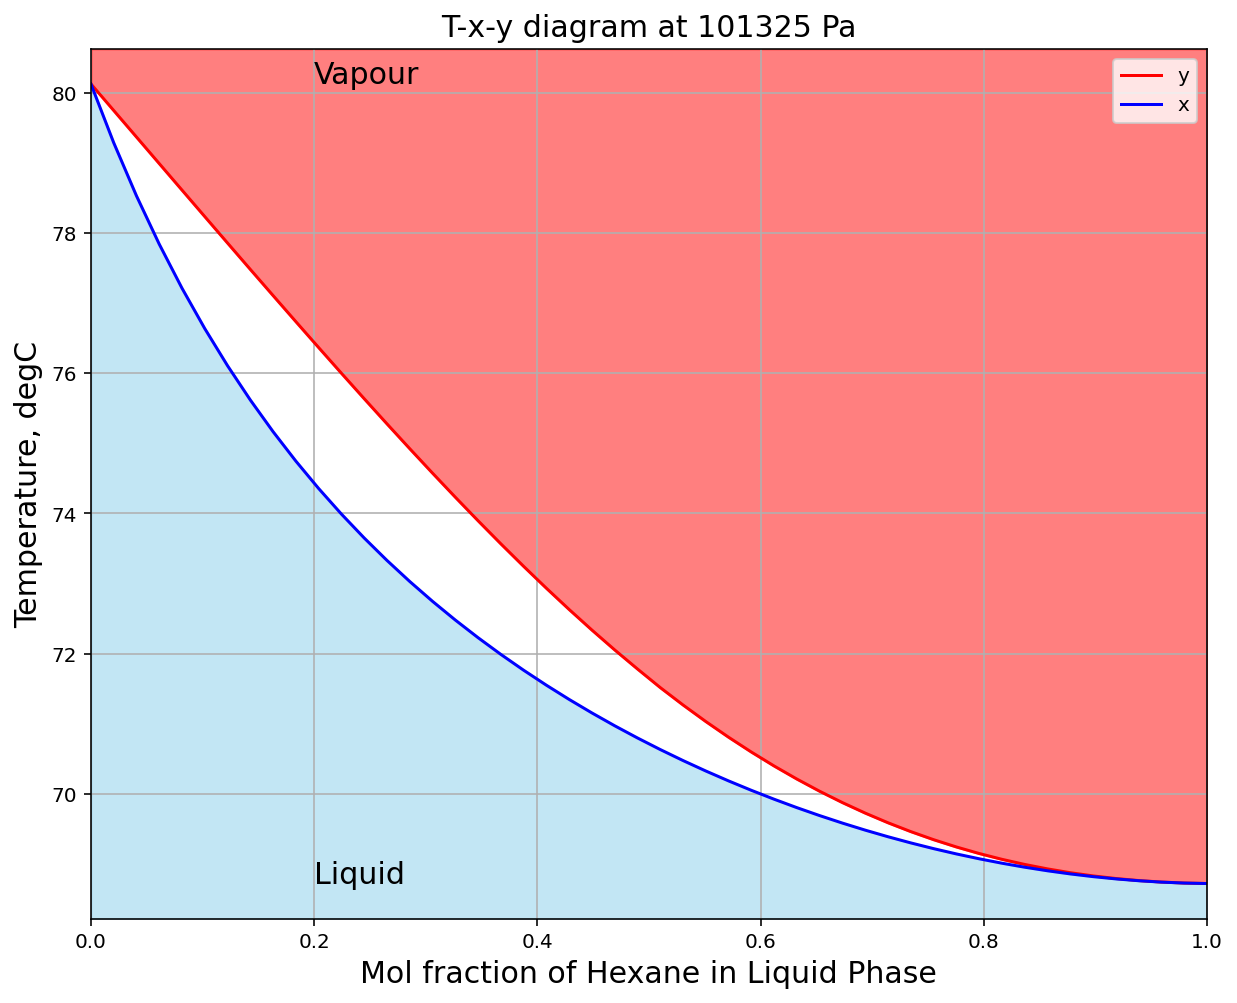

In [11]:
dist.show_xy()
dist.show_txy()


### The show_opline method will evaluate the necessary operations and then show the user how the Operating Lines and the q-line look:

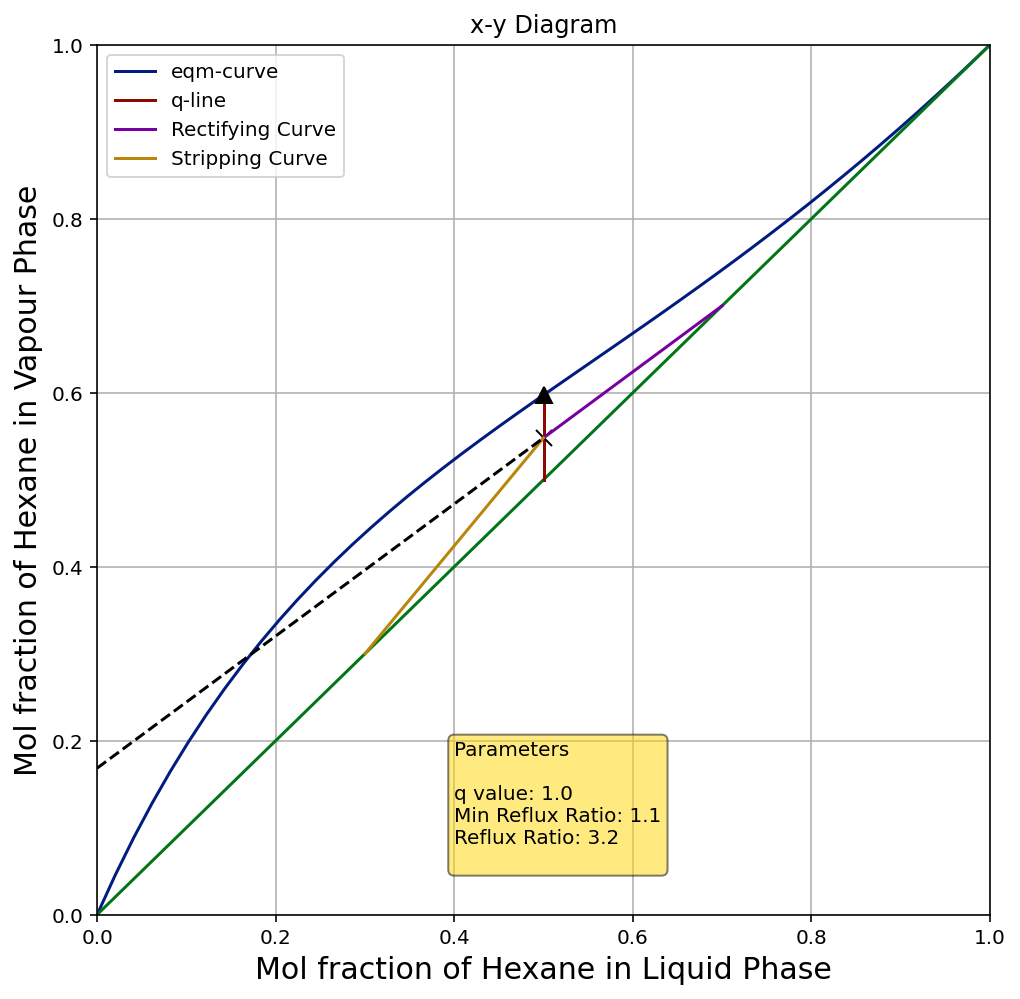

In [12]:
dist.show_opline()

### The num_stages method, will calculate the number of Ideal Stages required using the McCabe Thiele Method. The function will by default print the "Step Diagram". <br>Users can suppress it by adding an argument arg = False. 

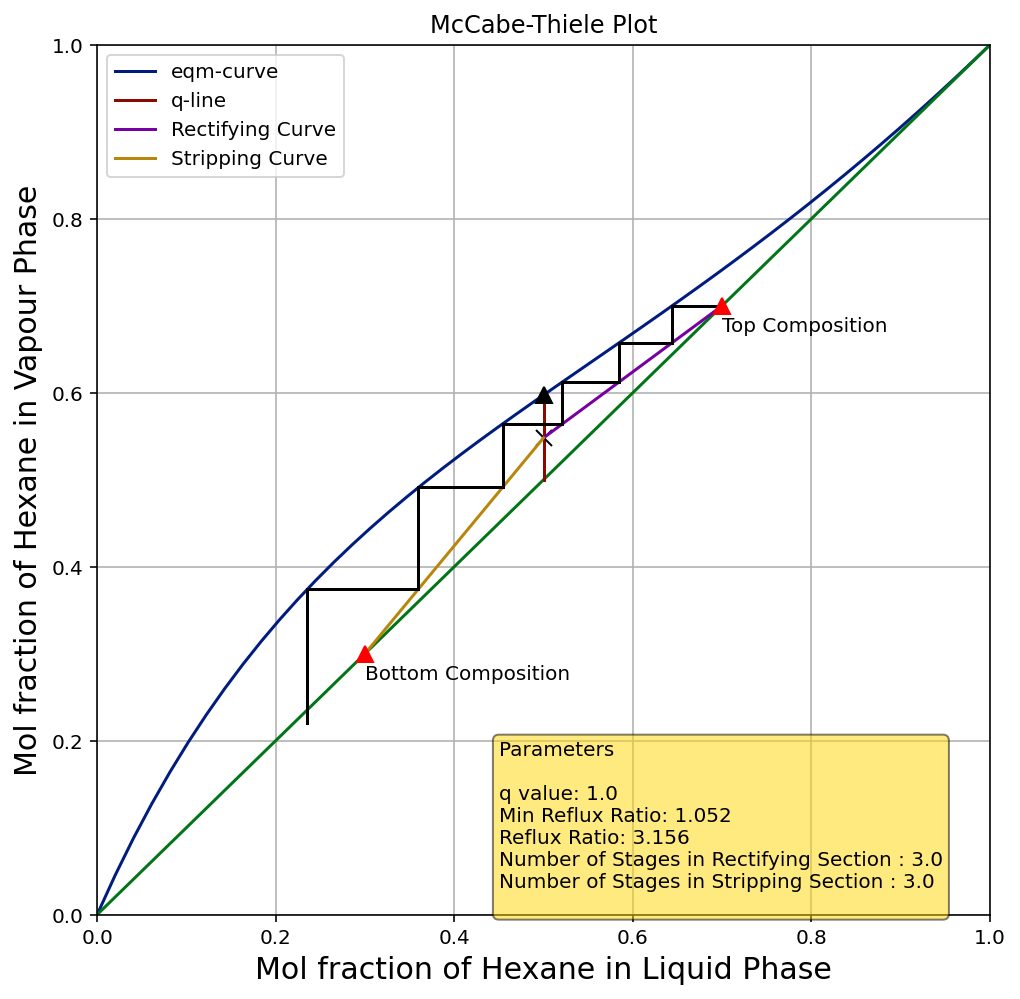

In [13]:
dist.num_stages()


### We have the method simulate_transient() that will carry out the mass balances across each stage and solve for the ODEs and saves an array for the corresponding solution. <br> The methodology followed is as followed:
<li> We have assumed $Constant \; Molal \; Overflow$ so the Volumetric flowrate of liquid and vapour is taken as constant in each of the Rectifying and the Stripping sections. This implies : $ L_{R} \;  = \; L_{1} \; + \; L_{2} \; .... \; +L{n}$ and $ V_{R} \;  = \; V_{1} \; + \; V_{2} \; .... \; +V{n}$
   
<li> We are assuming that the Liquid Hold Up in each stage is constant. $H$ = constant
    
<li> We are assuming that the vapour Hold Up in each stage is negligible. $h$ = 0
   
<li> We are assuming well mixed conditions where the vapour is completely saturated in each stage thus, $y_{n}\;=\;f(x_{n})$

<li> The ODEs are of form : $ H\frac{dx_{n}}{dt}\;=\;Vy_{n+1}\;+Lx_{n-1}\;-\;Lx_{n}\;-\;Vy_{n}$ 
    

### The simulate_transient() method takes in time as argument. This time is the total time we need to simulate the system.

In [14]:
time = 0.25  #hr
dist.simulate_transient(time)

### Now, the user has two options to Visualize the simulation results. First, user can see a simple animation of how the composition changes in some stages along with the bottom and top stages. We use the method show_anim() for this:

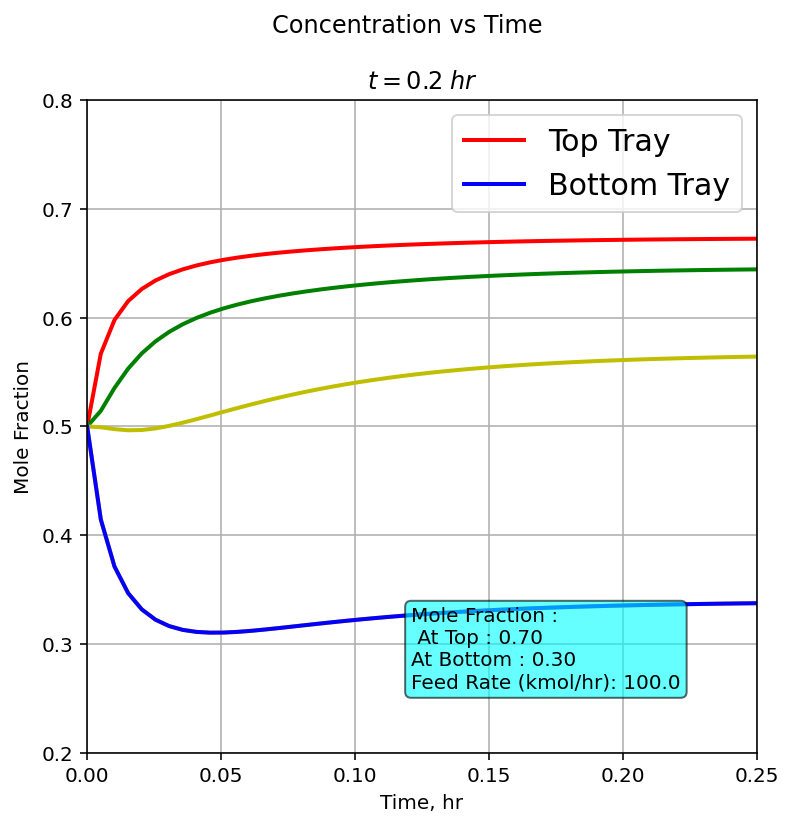

In [15]:
dist.show_anim()     
name = 'distillation_'+str(dist.names_list[0])+'_'+str(dist.names_list[1])+'.gif' 
IPdisplay.Image(url=name)


### The user can also see the simulation result in the form of a heat map, where each composition in each stage is represented by a coloor and the color changes as time passes. We can use the animate_stage() method for this purpose:

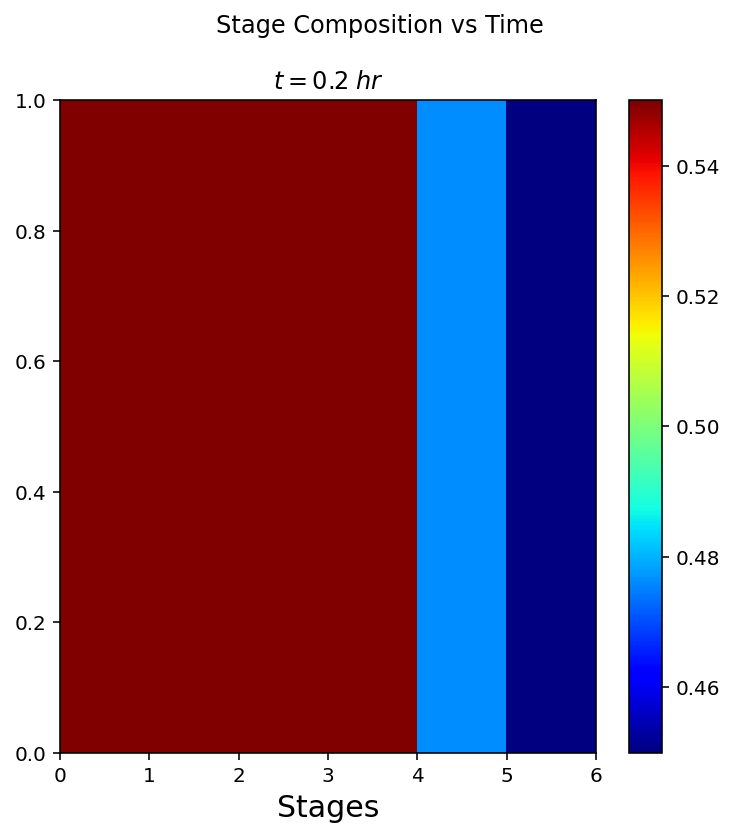

In [16]:
dist.animate_stage()     
name = 'distillation_stage'+str(dist.names_list[0])+'_'+str(dist.names_list[1])+'.gif' 
IPdisplay.Image(url=name)

### Lets try to do it for different system

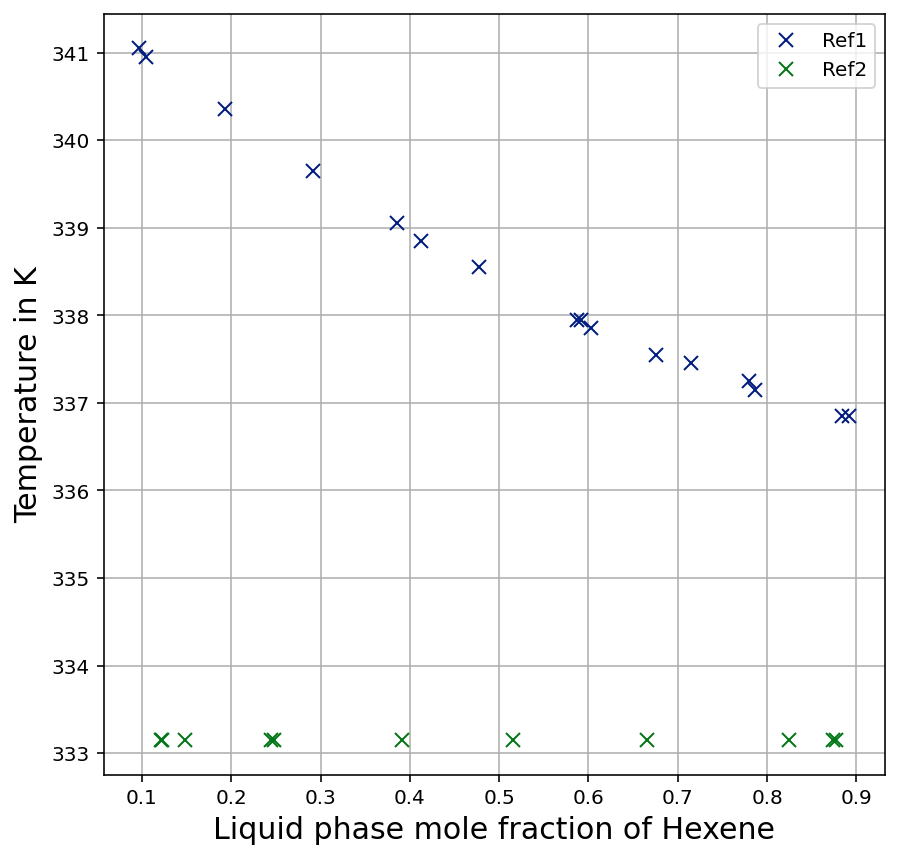

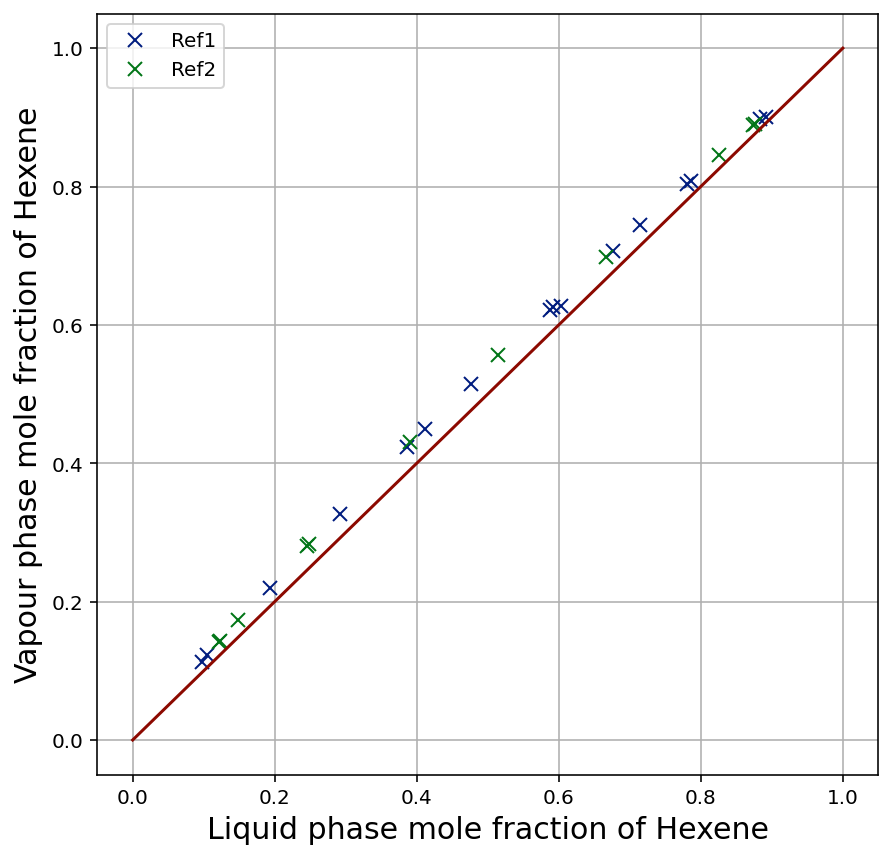

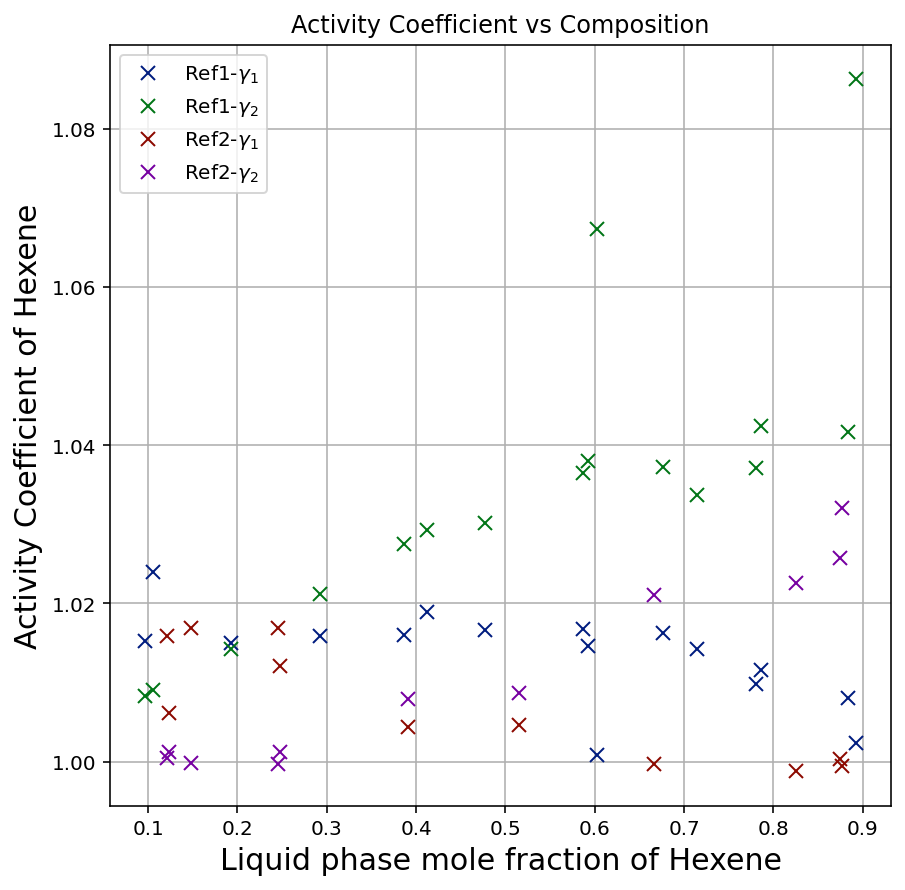

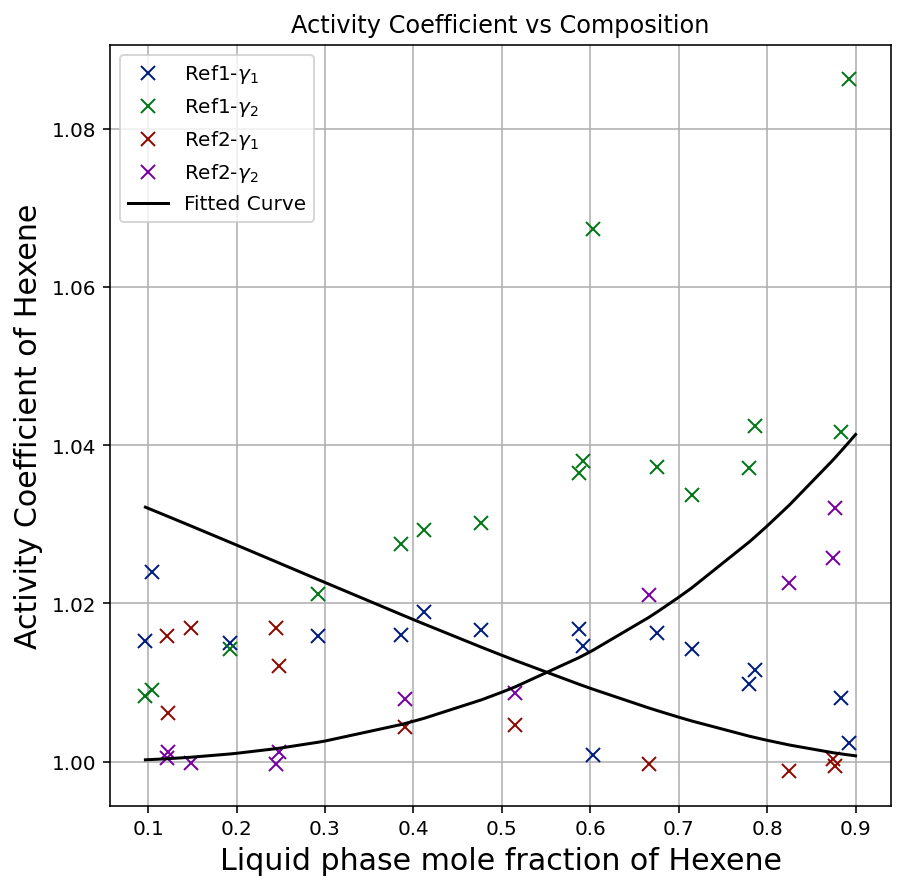

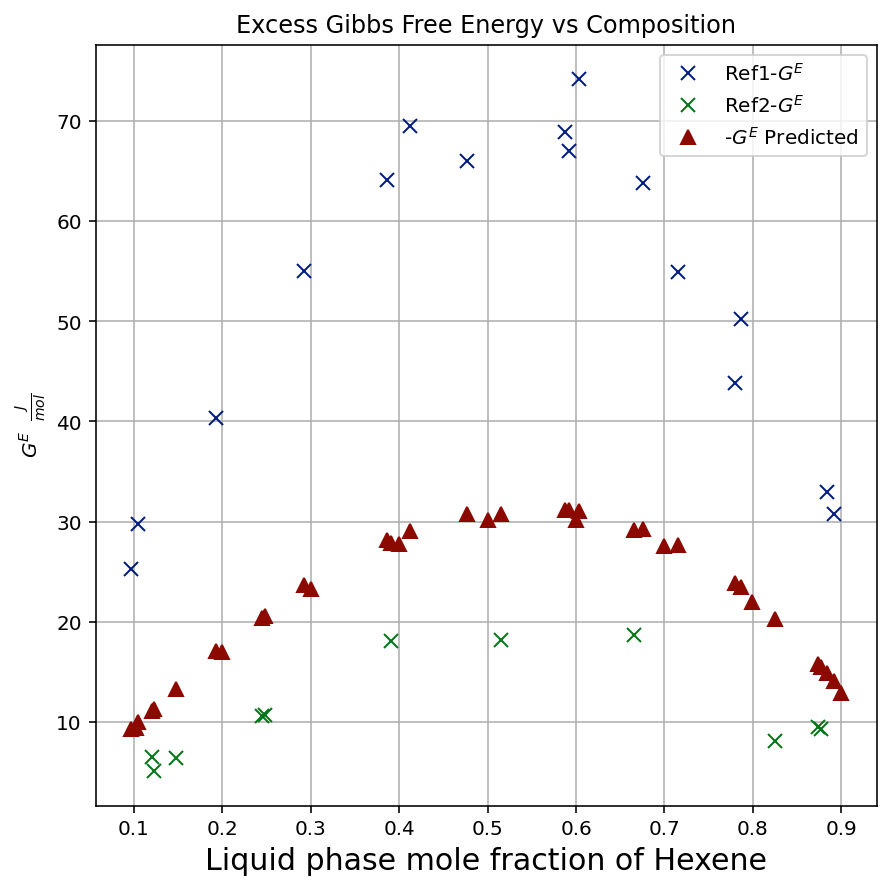

In [17]:
df_vle2 = pd.read_excel('hexane_hexene_VLE.xlsx', usecols = 'A:E')
VLEObj2 = AnalyzeVLE(['1-Hexene', 'n-Hexane'], df_vle2)
VLEObj2.initialize_reading()
VLEObj2.process_data(ref_no = 2)
VLEObj2.visualize_data()
VLEObj2.get_expt_gamma()
nrtl2, params2, cost2 = VLEObj2.fit_nrtl()
VLEObj2.observe_fit()


In [18]:
Hexene = purecomponentdata.Compound("1-Hexene")  # More volatile component, (1)
Hexane = purecomponentdata.Compound("n-Hexane")  # Lesser volatile component, (2)

dict_compounds2 = {"Hexene":Hexene, "Hexane":Hexane} # Define the dictionary

In [19]:
dist2 = BinaryDistillation(nrtl2, dict_compounds2)
dist2.xd = 0.75
dist2.xf = 0.5
dist2.q = 1
dist2.R = 3.5

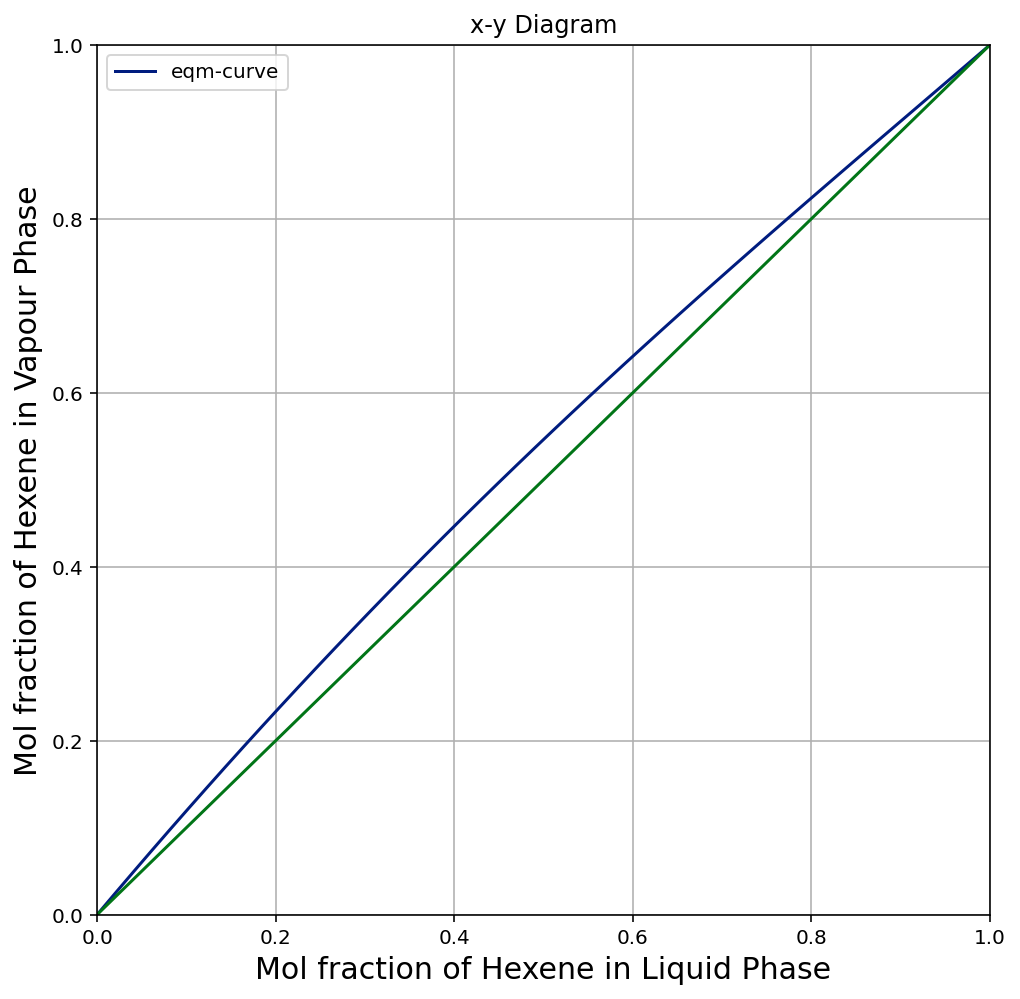

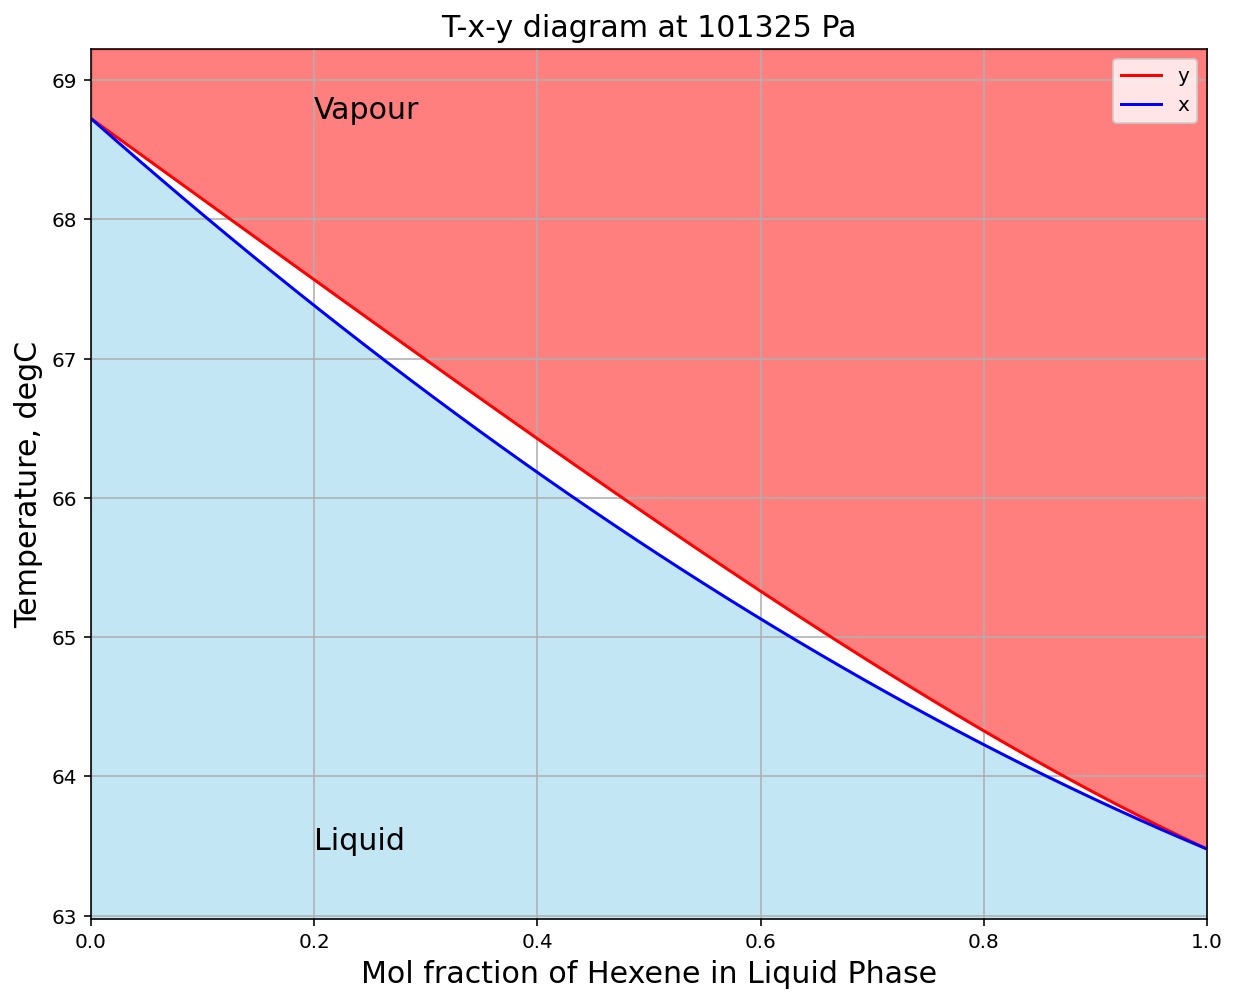

In [20]:
dist2.show_xy()
dist2.show_txy()

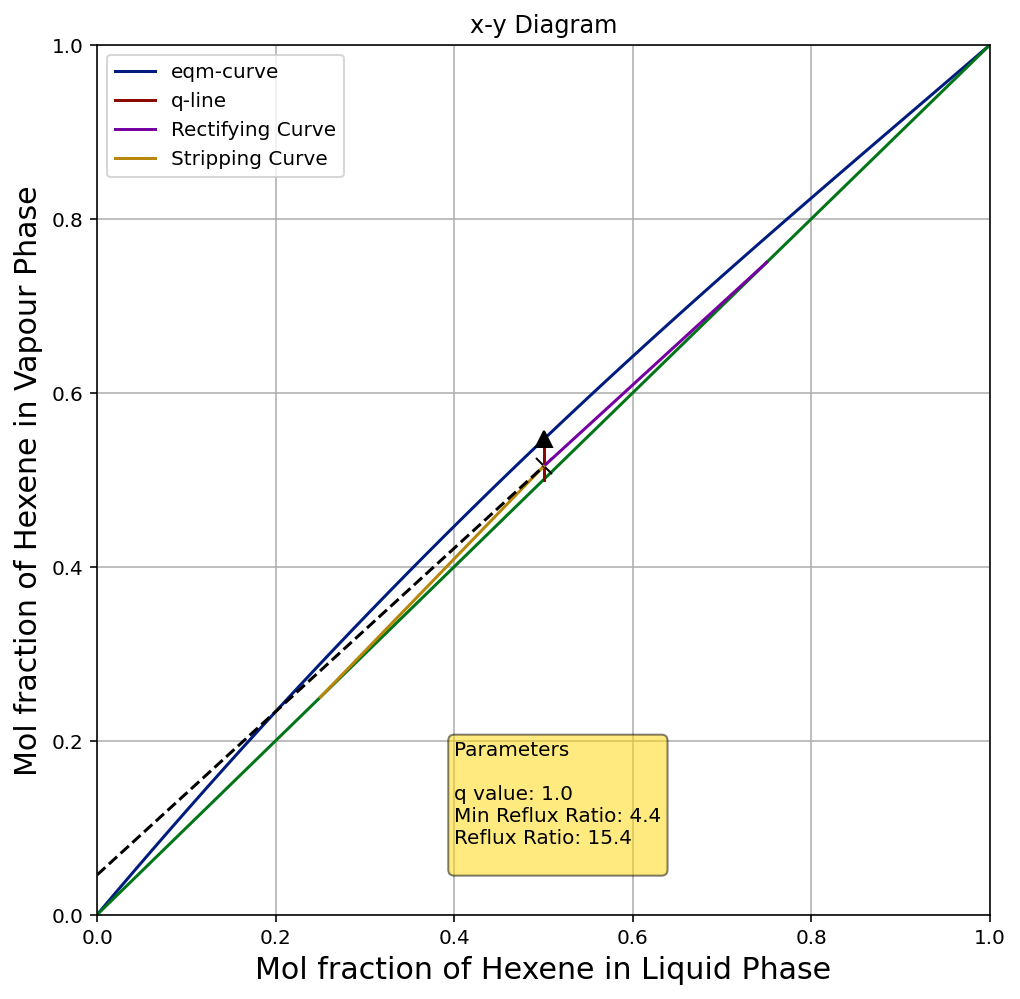

In [21]:
dist2.show_opline()

C:\Users\hp1\AppData\Roaming\Python\Python37\site-packages\scipy\optimize\minpack.py:175: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


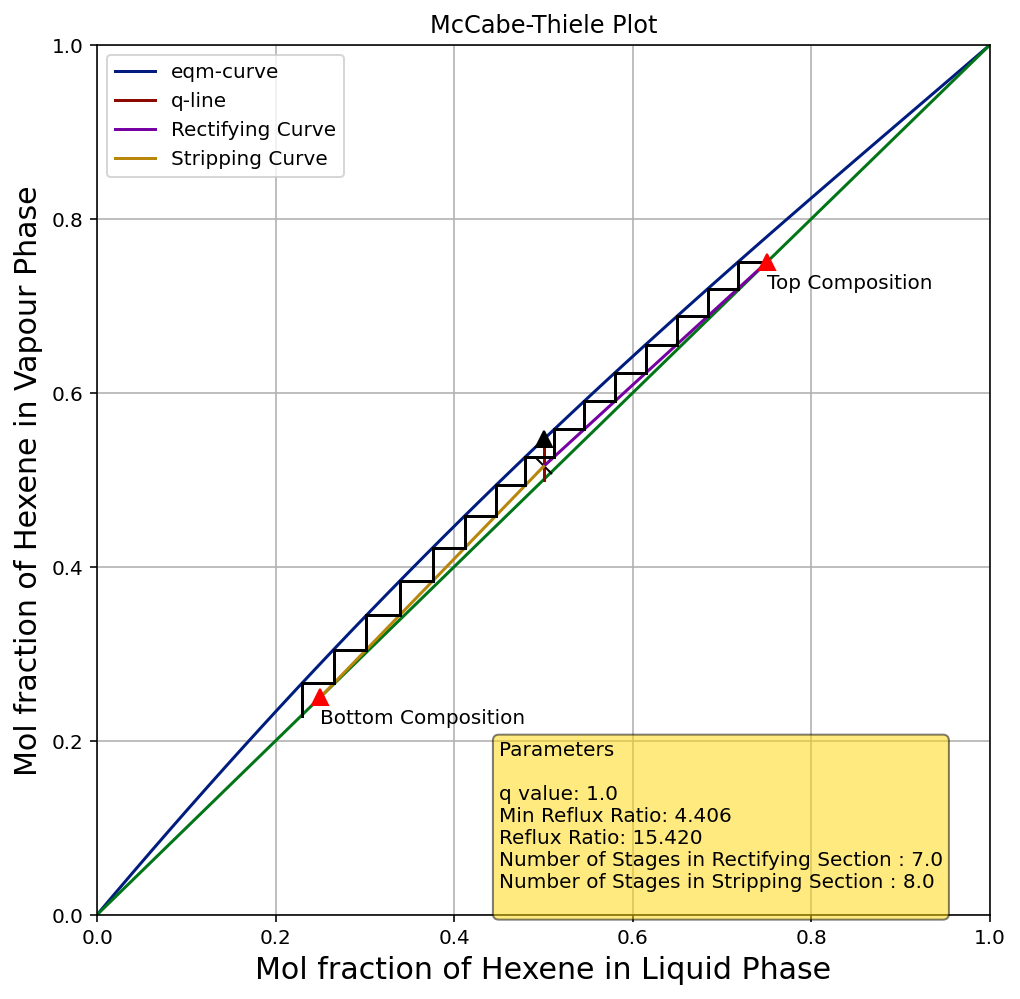

In [22]:
dist2.num_stages()

In [23]:
time = 0.3  #hr
dist2.simulate_transient(time)

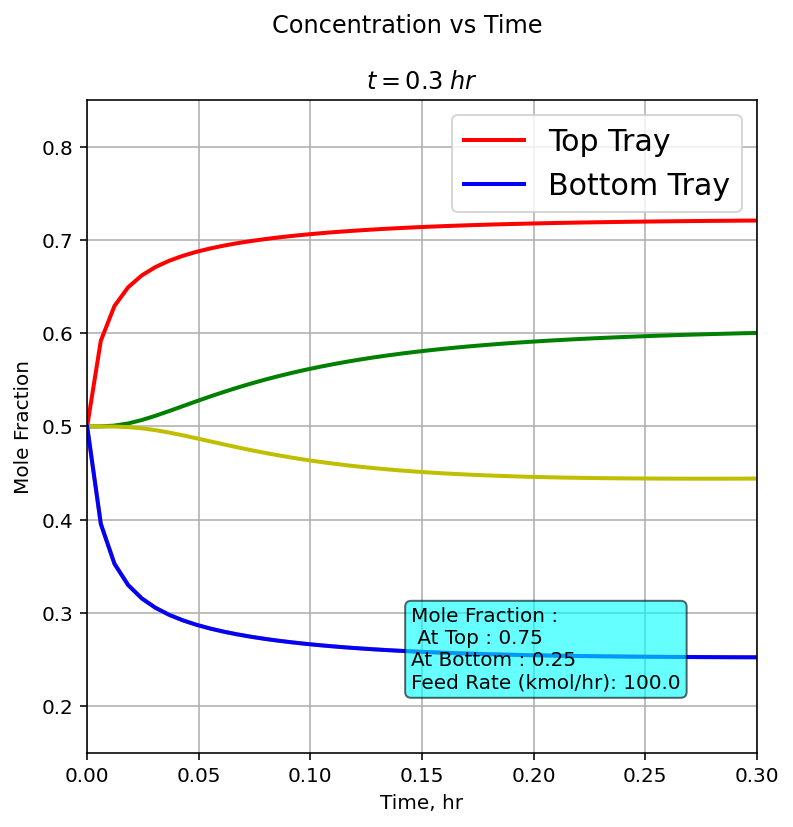

In [24]:
dist2.show_anim()     
name = 'distillation_'+str(dist2.names_list[0])+'_'+str(dist2.names_list[1])+'.gif' 
IPdisplay.Image(url=name)

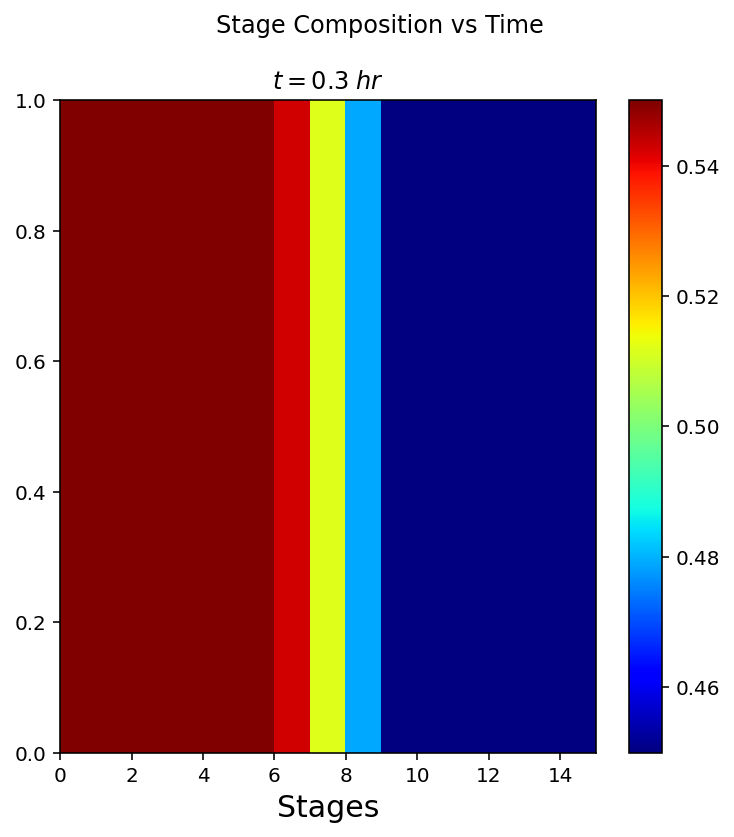

In [25]:
dist2.animate_stage()     
name = 'distillation_stage'+str(dist2.names_list[0])+'_'+str(dist2.names_list[1])+'.gif' 
IPdisplay.Image(url=name)

## One more system!

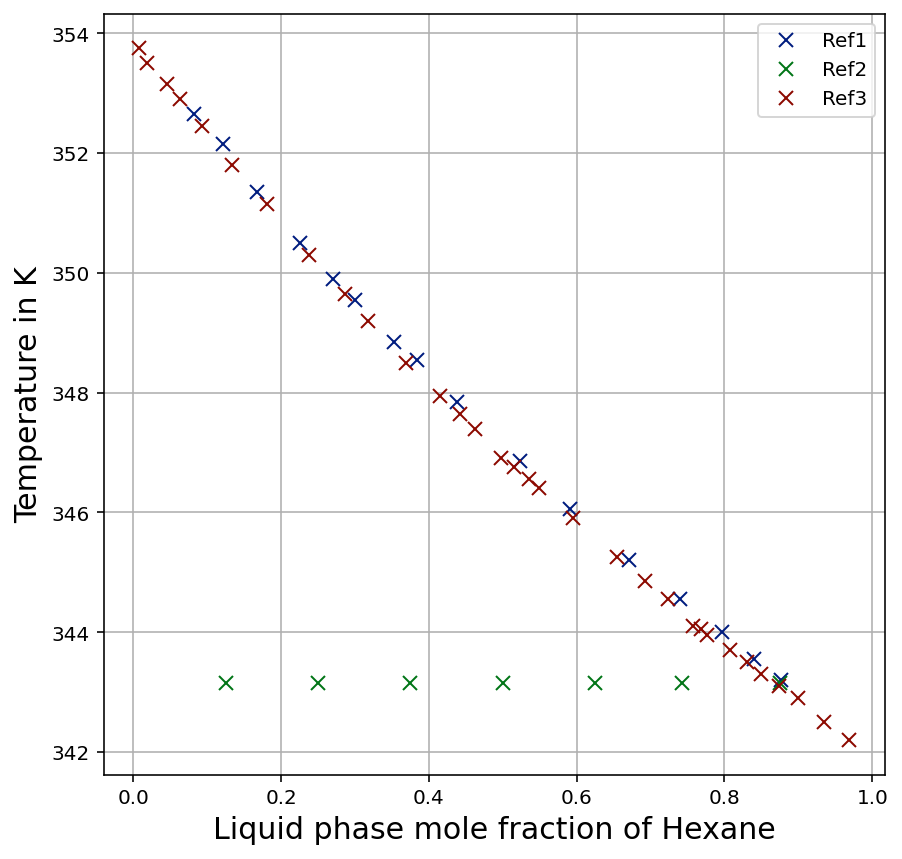

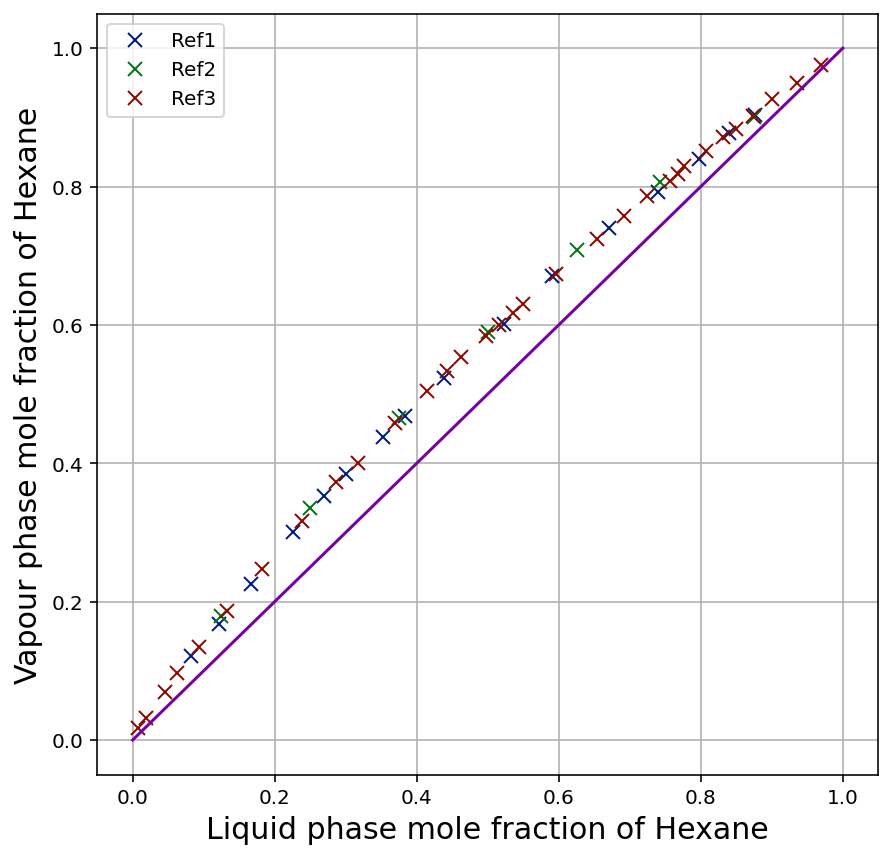

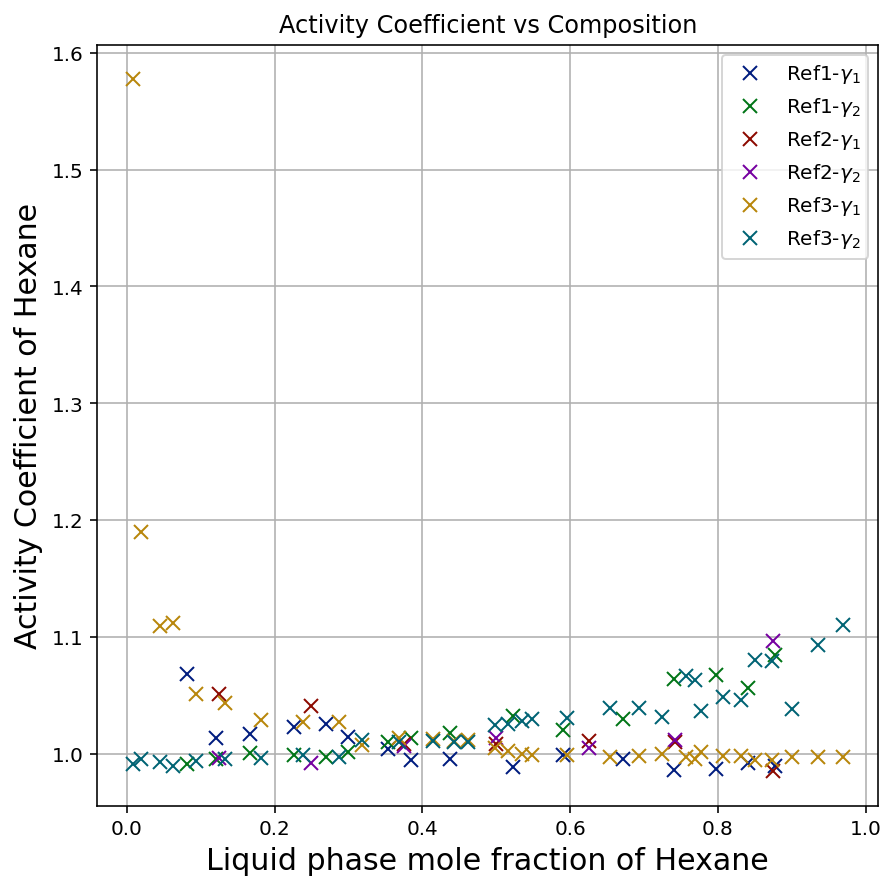

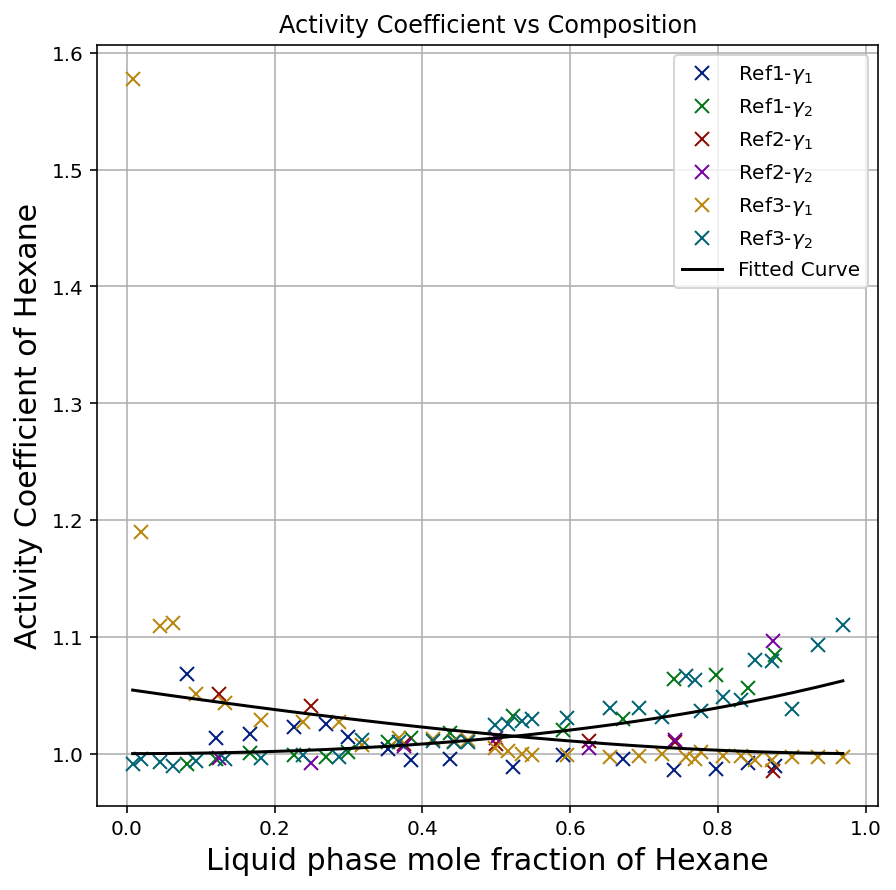

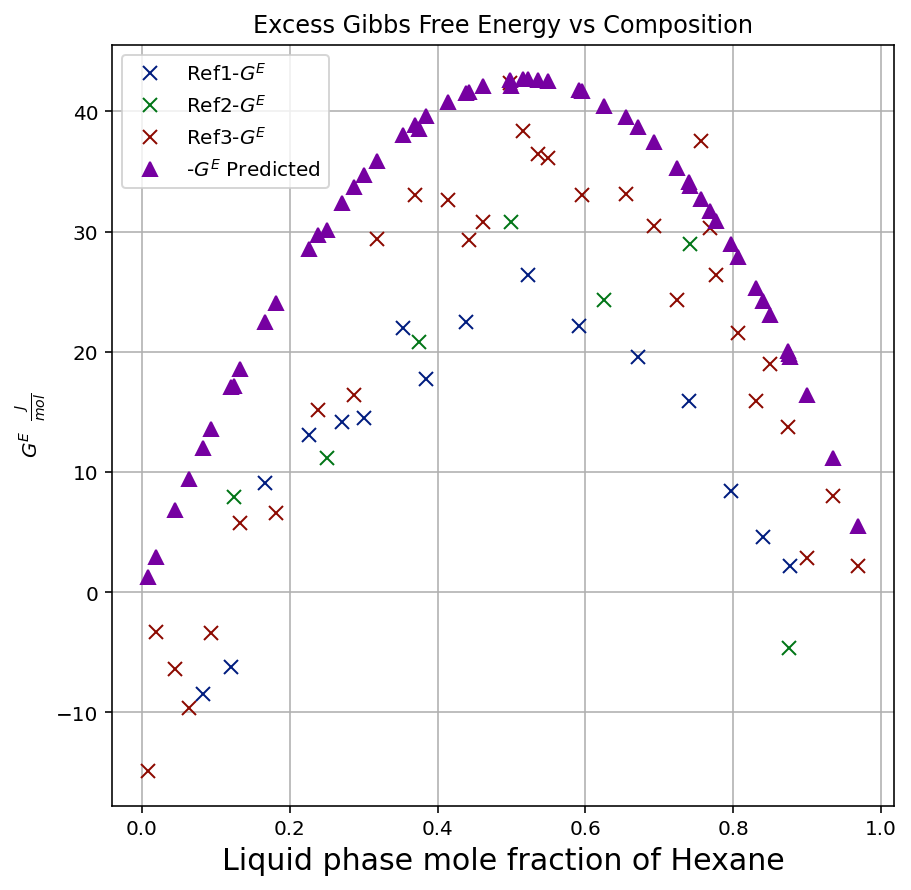

In [26]:
df_vle3 = pd.read_excel('hexane_cyclohexane_VLE.xlsx', usecols = 'A:E')
VLEObj3 = AnalyzeVLE(['n-Hexane', 'Cyclohexane'], df_vle3)
VLEObj3.initialize_reading()
VLEObj3.process_data()
VLEObj3.visualize_data()
VLEObj3.get_expt_gamma()
nrtl3, params3, cost3 = VLEObj3.fit_nrtl()
VLEObj3.observe_fit()

In [27]:
Hexane = purecomponentdata.Compound("n-Hexane")  # More volatile component, (1)
Cyclohexane = purecomponentdata.Compound("Cyclohexane")  # Lesser volatile component, (2)

dict_compounds3 = {"Hexane":Hexane, "Cyclohexane":Cyclohexane} # Define the dictionary

In [28]:
dist3 = BinaryDistillation(nrtl3, dict_compounds3)
dist3.F = 100
dist3.xd = 0.75
dist3.xf = 0.5
dist3.q = 0.5
dist3.R = 3

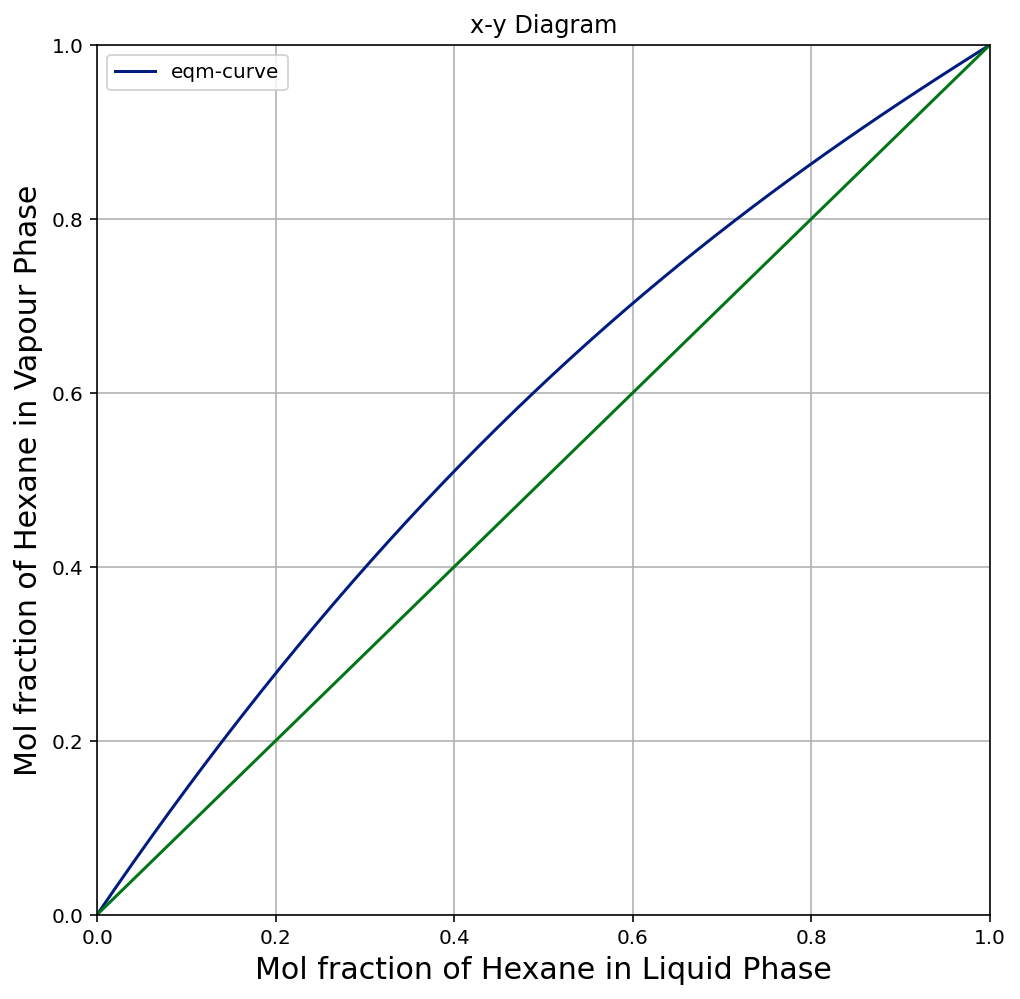

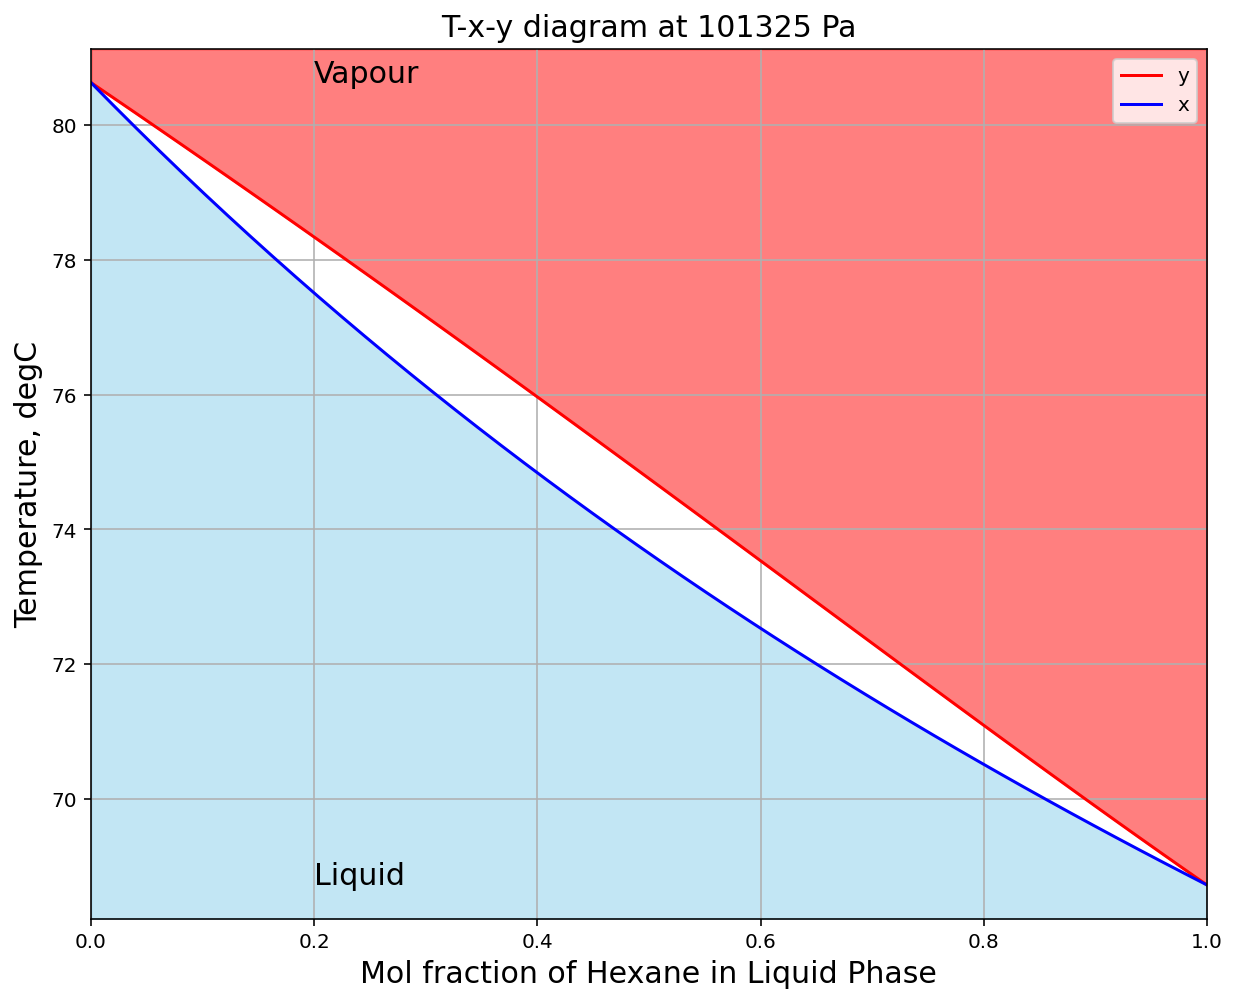

In [29]:
dist3.show_xy()
dist3.show_txy()

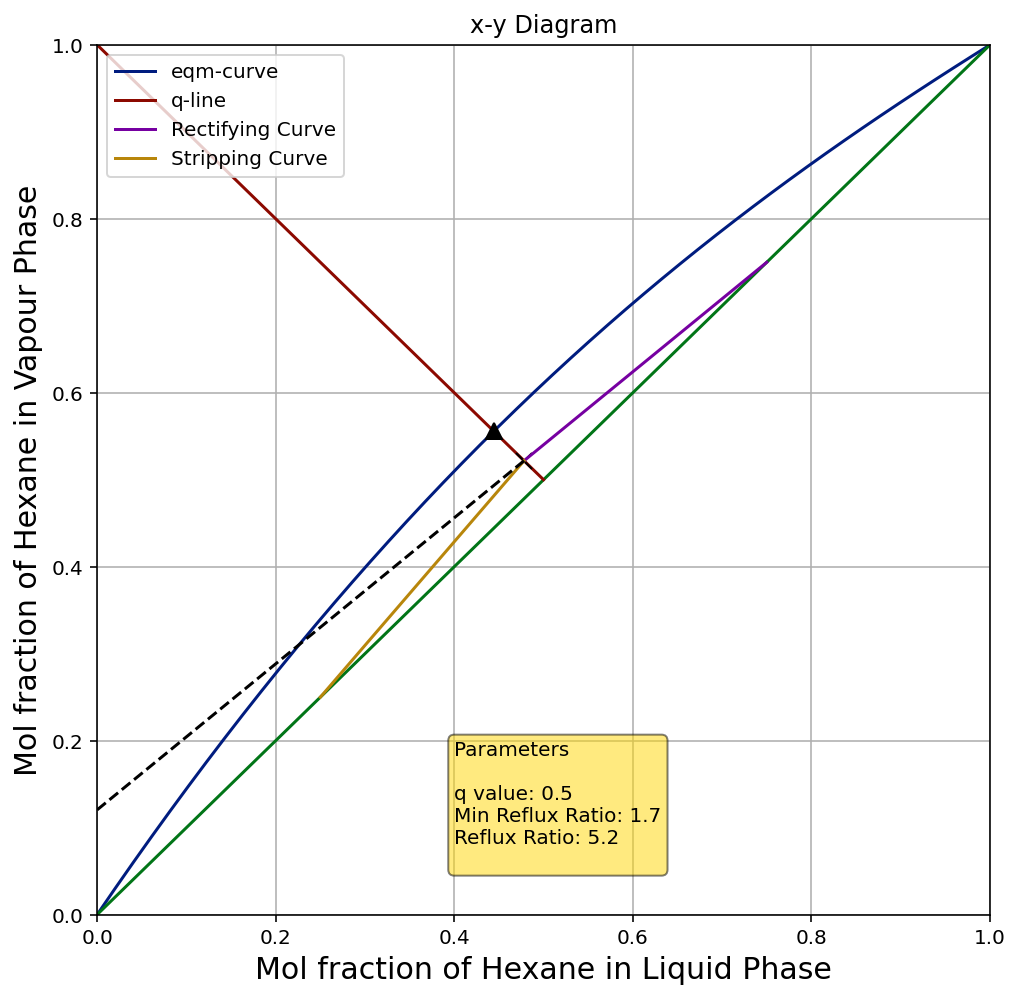

In [30]:
dist3.show_opline()

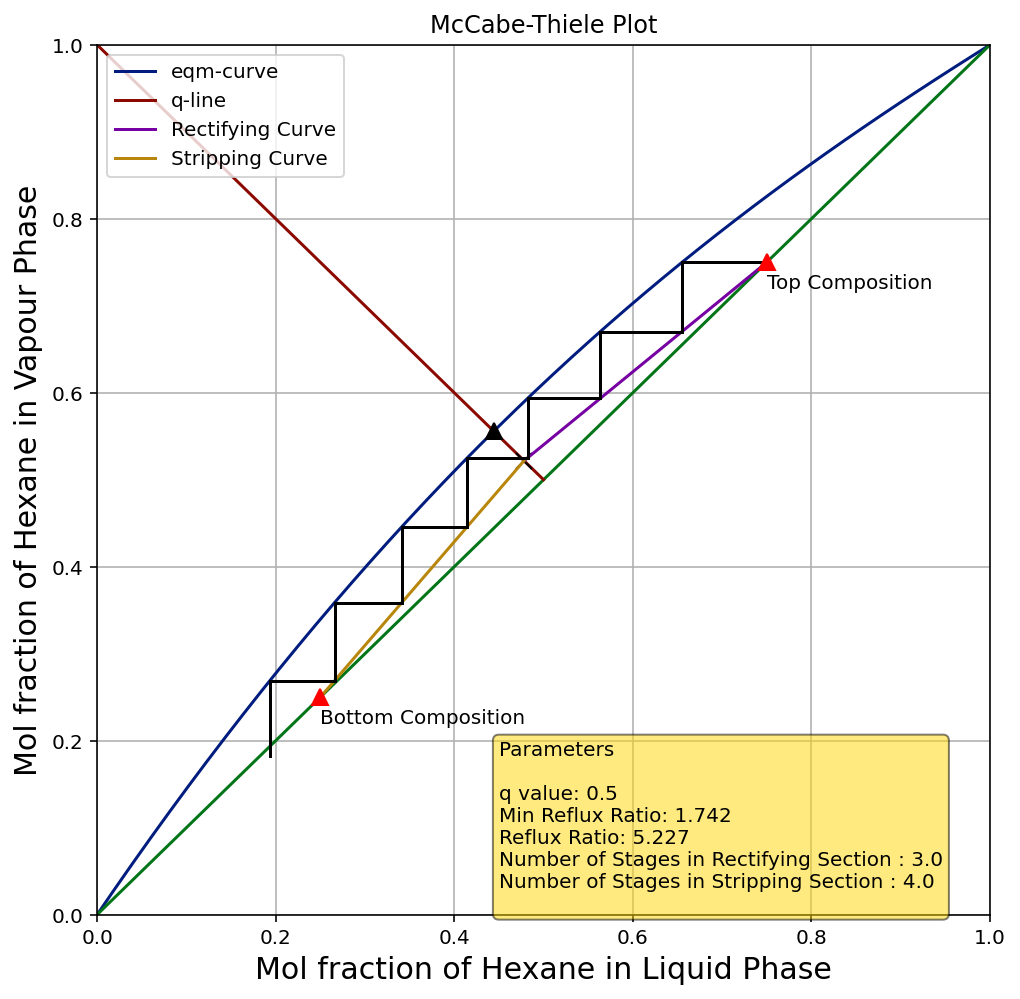

In [31]:
dist3.num_stages()

In [32]:
time = 0.05  #hr
dist3.simulate_transient(time)

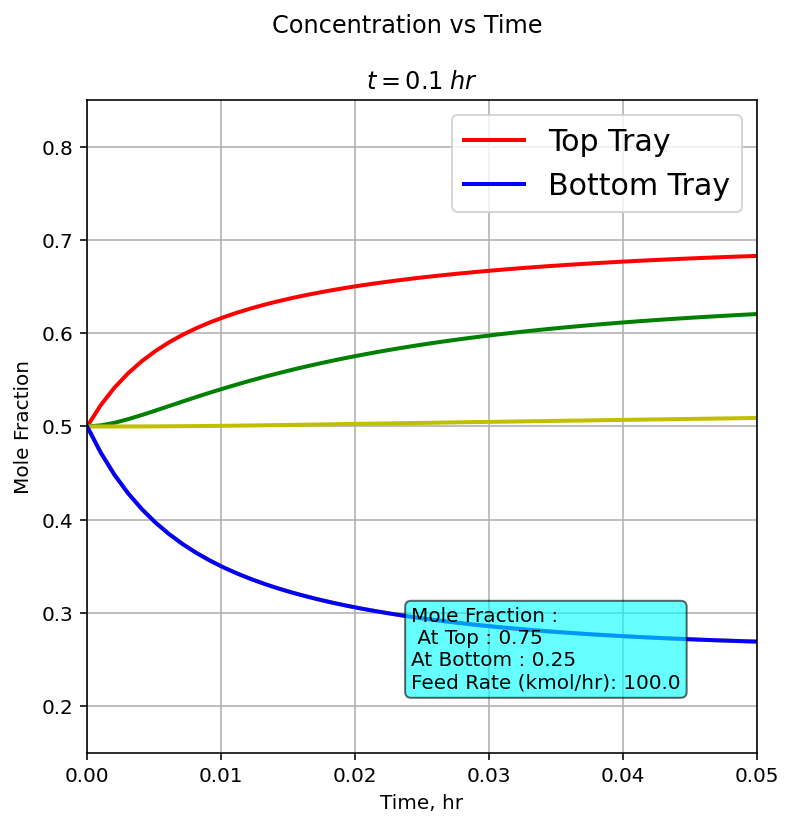

In [33]:
dist3.show_anim()     
name = 'distillation_'+str(dist3.names_list[0])+'_'+str(dist3.names_list[1])+'.gif' 
IPdisplay.Image(url=name)

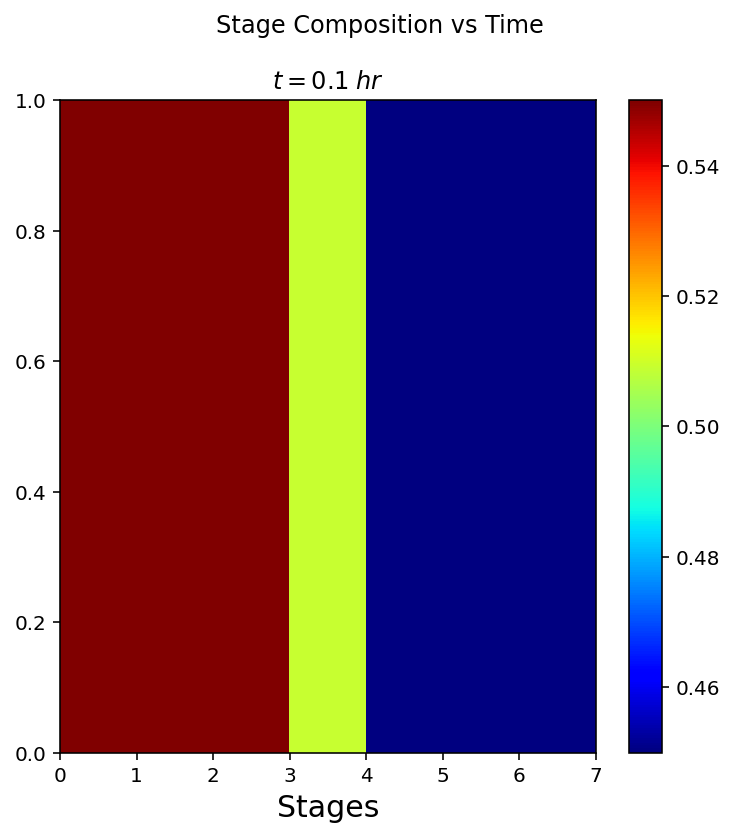

In [34]:
dist3.animate_stage()     
name = 'distillation_stage'+str(dist3.names_list[0])+'_'+str(dist3.names_list[1])+'.gif' 
IPdisplay.Image(url=name)